`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


!pip install watermark
%load_ext watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1


# Упражнение 4: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, случайный лес, дерево регрессии  


In [2]:
# выводим информацию о версиях python и пакетов
%watermark -a "aksyuk@github.com" -d -v -p numpy,pandas,matplotlib,sklearn 

Author: aksyuk@github.com

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy     : 1.19.5
pandas    : 1.1.5
matplotlib: 3.2.2
sklearn   : 0.0



# Указания к выполнению


## Загружаем пакеты

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import urllib
from pathlib import Path
from IPython.display import Markdown, display
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
import time
from sklearn import datasets


from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [4]:
my_seed = 20

plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [5]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

1. Visit [Drive folder](https://drive.google.com/drive/folders/1E9_u-v8chGmPwgROBEorD9hT609ysv_W?usp=sharing).

2. Right click on folder name -> "Add a shortcut to Drive" -> select "My Drive" -> "Add shortcut".

In [6]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# AUX_DATA_ROOT is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/data")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [7]:
import os 
DF_raw = pd.read_csv(os.path.join(AUX_DATA_ROOT, 'default_of_credit_card_clients.csv'))

print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [8]:
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

In [9]:
DF_raw.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Отложим 15% наблюдений для прогноза.  

In [10]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

DF - TRAIN
DF_predict - TEST

Для категориальных переменных SEX, EDUCATION и MARRIAGE подсчитаем частоты значений


In [11]:
count_sex = DF['SEX'].value_counts()
pd.DataFrame(count_sex)

,SEX
2,15408
1,10092


In [12]:
count_edu = DF['EDUCATION'].value_counts()
pd.DataFrame(count_edu)

,EDUCATION
2,11894
1,9055
3,4141
5,253
4,100
6,46
0,11


In [13]:
count_mar = DF['MARRIAGE'].value_counts()
pd.DataFrame(count_mar)

,MARRIAGE
2,13585
1,11605
3,261
0,49


Теперь перекодируем категориальные переменные SEX, EDUCATION и MARRIAGE с помощью OneHotEncoder

In [14]:
from sklearn.preprocessing import OneHotEncoder

nom_col_names=['SEX', 'EDUCATION', 'MARRIAGE']

one_hot=OneHotEncoder()

recoded=one_hot.fit_transform(DF[nom_col_names]).toarray()
clmns=one_hot.get_feature_names(nom_col_names)
df_dummy_nom=pd.DataFrame(recoded, columns=clmns)

print(df_dummy_nom.shape)
df_dummy_nom.head()

(25500, 13)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Сконкатенируем наши датафреймы и удалим ненужные столбцы

In [15]:
DF_num = pd.concat([DF.loc[:,DF.dtypes=='int64'].reset_index(),df_dummy_nom], axis=1)
DF_num = DF_num.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'index'], axis=1)
print('Размерность обучающего фрейма после перекодировки:', DF_num.shape)

print()
DF_num.head()

Размерность обучающего фрейма после перекодировки: (25500, 34)



,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,60000,28,1,2,0,0,0,0,47262,46226,47557,48464,49532,50552,0,2100,2000,2000,2000,3000,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,30000,34,2,-1,2,2,2,2,99568,32326,31840,37075,37662,36904,33000,33000,5810,1325,0,3095,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,50000,30,0,0,2,2,2,0,45948,50813,45393,49351,45473,48595,6012,10,8212,1200,4008,4407,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,240000,42,2,2,2,2,2,2,259511,258208,245397,245014,209834,195913,11000,0,12300,14288,0,6887,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300000,28,0,0,2,2,2,2,275855,286812,280337,318248,316147,303666,15000,7000,50000,12000,0,13000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Теперь сделаем то же самое на отложенных данных DF_predict

In [16]:
nom_col_names=['SEX', 'EDUCATION', 'MARRIAGE']

recoded = one_hot.fit_transform(DF_predict[nom_col_names]).toarray()
clmns = one_hot.get_feature_names(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

print(df_dummy_nom.shape)
df_dummy_nom.head()

(4500, 13)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Соединим и удалим ненужное

In [17]:
DF_predict = pd.concat([DF_predict.loc[:, DF_predict.dtypes=='int64'].reset_index(), df_dummy_nom], axis=1)
DF_predict = DF_predict.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'index'], axis=1)
print('Размерность тестового фрейма после перекодировки:', DF_predict.shape)

print()
DF_predict.head()

Размерность тестового фрейма после перекодировки: (4500, 34)



,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,140000,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50000,23,1,2,0,0,0,0,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,320000,49,0,0,0,-1,-1,-1,253286,246536,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

In [19]:
DF_num.head(5)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,60000,28,1,2,0,0,0,0,47262,46226,47557,48464,49532,50552,0,2100,2000,2000,2000,3000,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,30000,34,2,-1,2,2,2,2,99568,32326,31840,37075,37662,36904,33000,33000,5810,1325,0,3095,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,50000,30,0,0,2,2,2,0,45948,50813,45393,49351,45473,48595,6012,10,8212,1200,4008,4407,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,240000,42,2,2,2,2,2,2,259511,258208,245397,245014,209834,195913,11000,0,12300,14288,0,6887,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300000,28,0,0,2,2,2,2,275855,286812,280337,318248,316147,303666,15000,7000,50000,12000,0,13000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# выращиваем дерево на всех объясняющих
X = DF_num.drop(['Y'], axis=1)
y = DF_num['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

3685

In [21]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

67

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [22]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Accuracy с перекрёстной проверкой для модели', score_models[0], ':', score[0])

Accuracy с перекрёстной проверкой для модели one_tree : 0.727


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [23]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1598
Энтропия листьев для первых 5 значений alpha: [0.00131411 0.00131411 0.00131411 0.00134371 0.00137332]


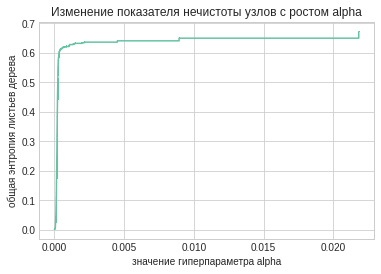

In [24]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [25]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 824.46 секунд


In [26]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 19.20 секунд


In [27]:
np.linspace(0, 0.09, num=10)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

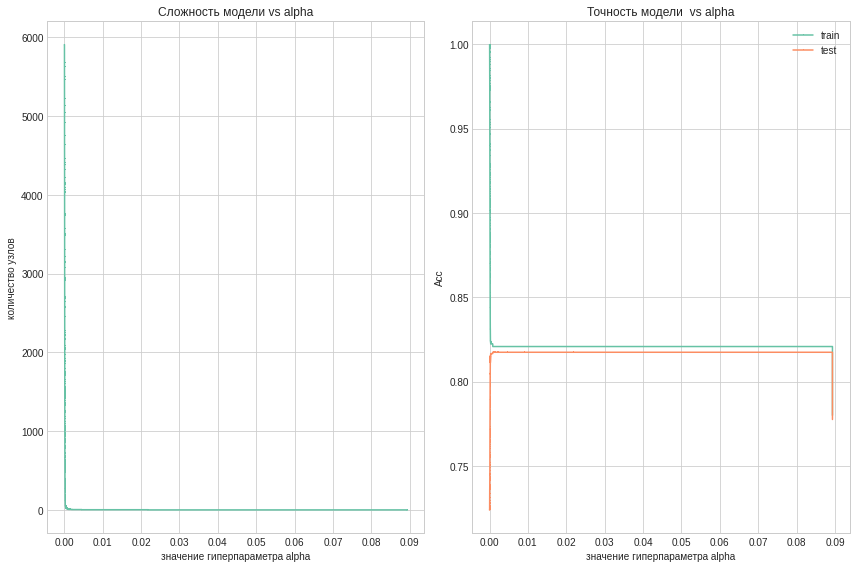

In [28]:
# изображаем на графике
fig, ax = plt.subplots(1, 2, figsize=(12,8))

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
ax[0].set_xticks(np.linspace(0, 0.09, num=10))

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].set_xticks(np.linspace(0, 0.09, num=10))
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [29]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой для модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 11 
соответствующая Acc на тестовой: 0.817 

Acc с перекрёстной проверкой для модели pruned_tree : 0.725


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [30]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2835

In [31]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

36

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [32]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 17, 11, 11, 9, 9, 9, 9, 9, 9, 7, 7, 5, 5, 3, 1]

In [33]:
plot_tree?

Количество узлов: 19 
Точность дерева на тестовой: 0.817


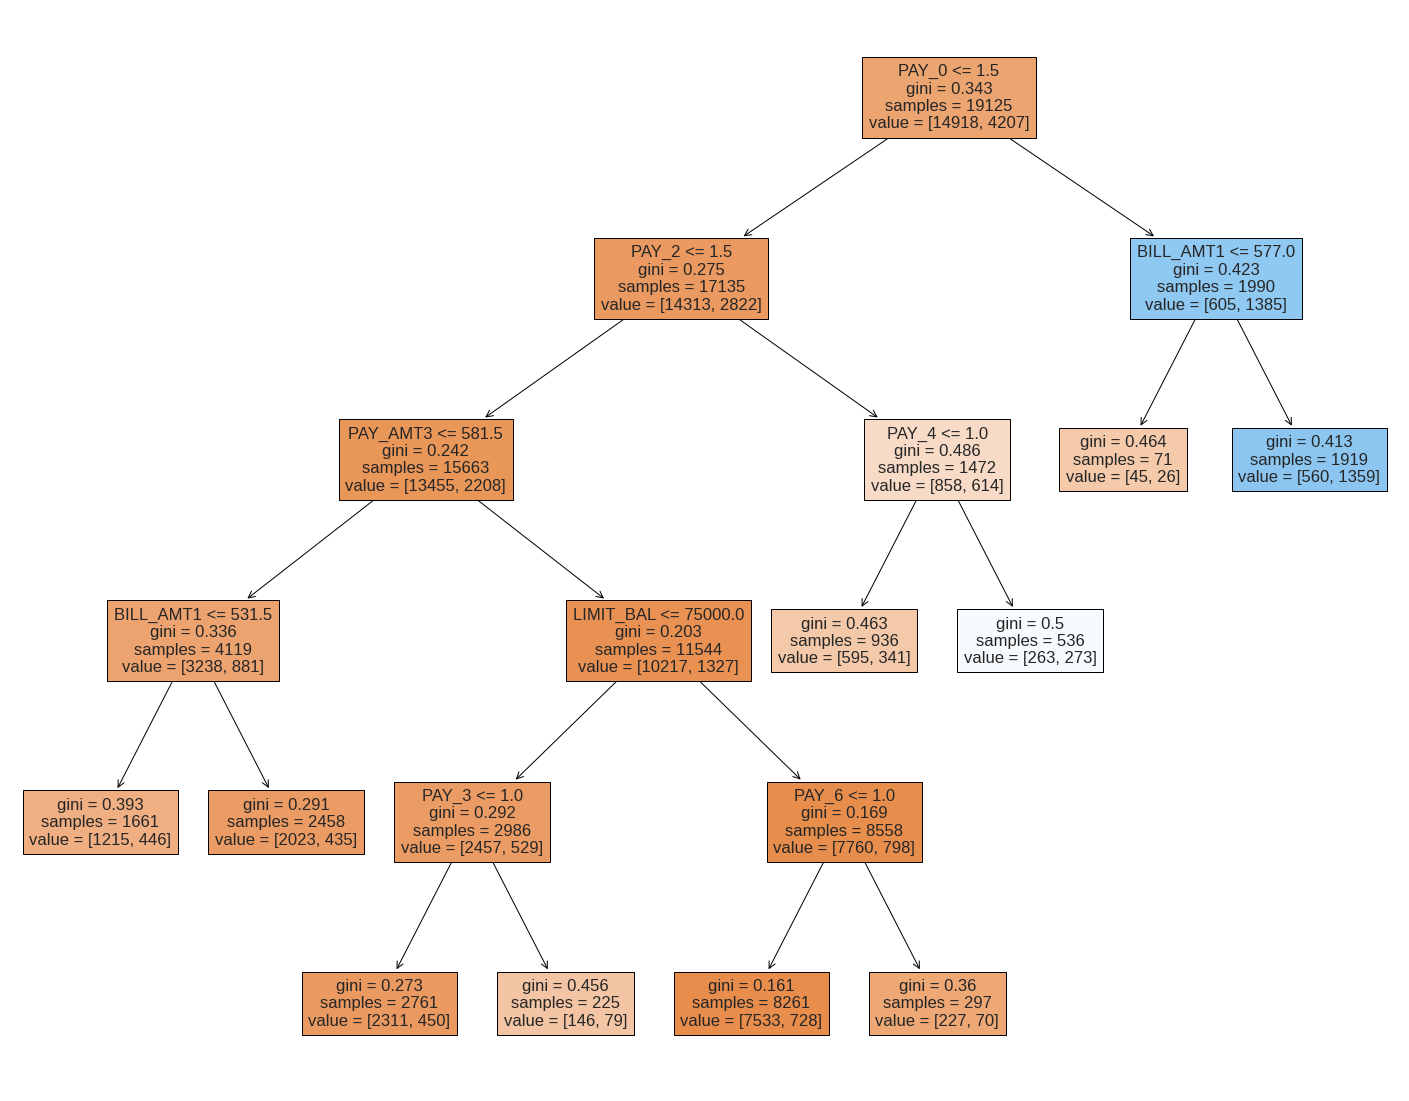

In [34]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [35]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- PAY_AMT3 <= 581.50
|   |   |   |--- BILL_AMT1 <= 531.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT1 >  531.50
|   |   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  581.50
|   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |--- PAY_3 <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PAY_3 >  1.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |--- PAY_6 <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PAY_6 >  1.00
|   |   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- PAY_4 <= 1.00
|   |   |   |--- class: 0
|   |   |--- PAY_4 >  1.00
|   |   |   |--- class: 1
|--- PAY_0 >  1.50
|   |--- BILL_AMT1 <= 577.00
|   |   |--- class: 0
|   |--- BILL_AMT1 >  577.00
|   |   |--- class: 1



# Случайный лес  



У модели случайного леса два настроечных параметра: количество деревьев $B$ и количество признаков для построения отдельного дерева $m$. Настроим сеточный поиск для их подбора.  

In [36]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([33, 16,  6,  5])

In [37]:
# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
              'max_features' : ms}

kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 497.71 секунд


In [38]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.815

In [39]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

50

In [40]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

16

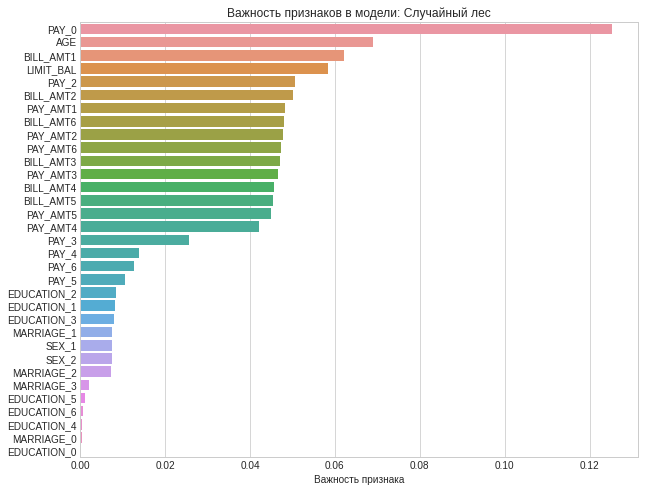

In [41]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [43]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой для модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой для модели random_forest_GS : 0.815



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [44]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.727
1,pruned_tree,0.725
2,random_forest_GS,0.815
3,random_forest_GS,0.815


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения.   

In [45]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3489
           1       0.68      0.35      0.46      1011

    accuracy                           0.82      4500
   macro avg       0.76      0.65      0.67      4500
weighted avg       0.80      0.82      0.79      4500



##6 Пункт
В упражнении 3 наибольшую точность показывает Лассо-регрессия (0,811)
В упражнении 4 random forest (0,815)

# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  